<a href="https://colab.research.google.com/github/Shreyankthehacker/RAG/blob/main/RAG_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## State Model

Represents the state of a user-chat interaction.

| Field         | Type | Description                                |
|---------------|------|--------------------------------------------|
| `question`    | str  | Question given by the user                 |
| `answer`      | str  | Answer given by the application            |
| `chat_summary`| str  | Chat history maintained by the application |


In [ ]:
from pydantic import BaseModel,Field

class State(BaseModel):
    question : str = Field(description= "Question given be the user")
    answer : str = Field(description="Answer given by the Application")
    chat_summary : str = Field(description="Chat history maintained by the applciation")



## `file_router` Function

Determines the type of an input file and returns a routing identifier based on its content.

### Dependencies
- `filetype`
- `langchain.document_loaders.PyPDFLoader`

### Signature
```python
def file_router(file) -> str:
```

### Parameters
| Name  | Type     | Description                             |
|--------|----------|-----------------------------------------|
| `file` | Any file | The file to be analyzed and routed.     |

### Returns
A string indicating the file type:
- `"imagesingle"` – If the file is an image.
- `"imagepdf"` – If the file is a PDF **without text content** (likely image-based).
- `"pdf"` – If the file is a PDF **with extractable text content**.
- `"Unknown"` – If the file type cannot be determined.

### Logic
1. Uses `filetype.guess` to detect file type.
2. Routes images directly as `"imagesingle"`.
3. If it's a PDF:
   - Loads it using `PyPDFLoader`.
   - If the first page has no text content, it's considered an `"imagepdf"`.
   - Otherwise, it's a standard `"pdf"`.


In [ ]:
import filetype
from langchain.document_loaders import PyPDFLoader

def file_router(file):
    kind = filetype.guess(file)
    if kind is None:
        return "Unknown"
    file_type =  kind.mime
    if file_type.startswith("image/"):
        return 'imagesingle'

    # or else this is pdf and if there is images kind of pdf then return 'image' or text based then return pdf

    loader = PyPDFLoader(file)

    docs = loader.load()

    if not len(docs[0].page_content):
        return 'imagepdf'

    else :
        return 'pdf'








In [ ]:
GOOGLE_API_KEY = ---------------------------

## 🧠 `image_handler` – Image-Based Summarization (Beyond OCR)

This function processes an input image and generates a **highly structured, exhaustive summary** using **Google Gemini 2.0 Flash**, specifically designed to **capture all visual details** rather than just extracting raw text like traditional OCR.

---

### 🔍 Key Difference from OCR

Unlike OCR (Optical Character Recognition), which **only extracts visible text**, this approach uses **multimodal AI (Gemini)** to:

- Understand **visual structure**, layout, colors, formatting
- Extract **tables, figures, headers, and annotations**
- Describe **non-textual elements** like charts, icons, and logos
- Preserve **hierarchical structure** (e.g., titles, subheaders, footnotes)

This is particularly useful when:
- The image is a document scan, slide, or infographic
- Important info exists outside of plain text (like graphs or layout)
- You need a **deep, explainable summary** suitable for AI pipelines or search

---

### 🧱 Components

| Function             | Purpose                                                  |
|----------------------|----------------------------------------------------------|
| `encode_image()`     | Converts a `PIL.Image` into a base64-encoded PNG string |
| `image_summarize()`  | Invokes Gemini model to summarize the image             |
| `image_handler()`    | Main handler that processes image and writes output     |

---

### 💬 Prompt Highlights

The image is passed along with a **meticulous and structured prompt** that instructs the model to:

- Avoid generalization or paraphrasing
- Output bullet points, sections, tables as seen
- Highlight fonts, layout, formatting, and colors
- Include **everything** visible — text, graphics, numbers, etc.

---

### 📝 Output

- The final structured summary is saved in a file named `example.txt`
- Returned as a string for further programmatic use

---

### ✅ Example Use

```python
from PIL import Image
img = Image.open("sample_infographic.png")
result = image_handler(img)
print(result)
```

---

This approach ensures **maximum fidelity** in capturing what's in the image — making it ideal for **AI pipelines**, **document search**, and **detailed visual understanding** tasks.


In [ ]:
from langchain_chroma import Chroma

from langchain_google_genai import ChatGoogleGenerativeAI
import os
import base64
from langchain_core.messages import HumanMessage
from io import BytesIO

model = llm = ChatGoogleGenerativeAI(model = 'gemini-2.0-flash')

def encode_image(image) -> str:
    """Encode a PIL image to base64 string."""
    buffer = BytesIO()
    image.save(buffer, format="PNG")
    return base64.b64encode(buffer.getvalue()).decode("utf-8")

def image_summarize(model, base64_image: str, prompt: str) -> str:
    """Make image summary"""
    msg = model.invoke(
        [
            HumanMessage(
                content=[
                    {"type": "text", "text": prompt},
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:image/png;base64,{base64_image}"},
                    },
                ]
            )
        ]
    )
    return msg.content


image_prompt = """You are a highly meticulous AI assistant that extracts and summarizes every possible piece of visual information from an image without omitting any detail.
    Your task is to generate an exhaustive, structured summary of the image that captures all the text, visual elements, layout, colors (if relevant), numbers, figures, and any context or formatting that might be useful.
    Do not generalize or paraphrase — capture the content exactly as it appears. Use bullet points, lists, or structured sections (e.g., titles, tables, headers, footnotes) to organize your summary.

    Be especially attentive to:
    - All visible text, including headers, footnotes, and marginal notes
    - Tables: Capture each row and column verbatim including headers and cell values
    - Graphs/Charts: Explain all axes, labels, legends, data points, patterns, and conclusions
    - Visual layout and structure: Describe how content is arranged (e.g., two-column layout, centered title, left-aligned figure)
    - Icons, logos, or images embedded within the image: Describe them accurately
    - Fonts, colors, and emphasis (e.g., bold, italic, underlined) if they seem meaningful
    - Dates, numbers, symbols, or special formatting exactly as shown
    - If the image is a document or scanned page, preserve hierarchy and document structure

    Output the result in structured markdown with clear section headers (e.g., "Header", "Table 1", "Figure Description", "Text Body", "Footnotes").
    Your goal is to allow someone to fully understand the image without seeing it, preserving maximum detail for use in downstream AI models or search systems."""



def image_handler(image):

    base64_img = encode_image(image)
    summary = image_summarize(model, base64_img, prompt=image_prompt)
    with open('example.txt','w') as f:
        f.write(summary)
    return summary





In [ ]:
def image_handler_append(image):
    base64_img = encode_image(image)
    summary = image_summarize(model, base64_img, prompt=image_prompt)

    # Append instead of overwrite
    with open('example.txt', 'a') as f:
        f.write(summary + '\n')  # Add newline for separation

    return summary


## 🗂️ Chroma Vector Store for Image Summaries

This setup uses **Chroma** as the vector database to store and retrieve **detailed summaries of images**, enabling multimodal search and retrieval via embeddings.

---

### 💡 Purpose

Instead of storing raw images or applying traditional OCR, this pipeline:
- Summarizes each image using a **vision-language model** (e.g., Gemini)
- Embeds the summary text using **Hugging Face embeddings**
- Stores the embeddings in **Chroma DB** with metadata
- Enables fast, vector-based similarity search across images (via their summaries)

---

### ⚙️ Components

| Component         | Description                                                      |
|------------------|------------------------------------------------------------------|
| `HuggingFaceEmbeddings` | Generates embeddings for image summaries using Sentence Transformers |
| `Chroma`          | Vector store for embedding persistence and retrieval             |
| `image_handler()` | Converts images into structured summaries (see previous docs)    |

---

### 🧠 Workflow

1. **Summarize Image**
    ```python
    summary = image_handler(image)
    ```

2. **Embed Summary**
    ```python
    from langchain.embeddings import HuggingFaceEmbeddings

    embedder = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
    ```

3. **Store in Chroma**
    ```python
    from langchain_chroma import Chroma
    from langchain.schema import Document

    vectorstore = Chroma(collection_name="image_summaries", embedding_function=embedder)

    doc = Document(page_content=summary, metadata={"source": "example.jpg"})
    vectorstore.add_documents([doc])
    ```

---

### 🔍 Example Query

To find similar images via their summaries:
```python
query = "A scanned document with a bar chart and footnotes"
results = vectorstore.similarity_search(query, k=3)

for r in results:
    print(r.page_content)
    print("Source:", r.metadata["source"])
```

---

### 🏷️ Metadata Suggestions

Use metadata fields to enrich retrieval:
- `"source"`: original image filename or ID
- `"date"`: when the image was processed
- `"tags"`: manual tags or auto-extracted categories

---

### ✅ Benefits

- Richer than OCR: captures structure, layout, and non-text visuals
- Efficient retrieval: Chroma enables fast and scalable similarity search
- Flexible integration: easily extendable to support hybrid search (image + text)

---

This setup is ideal for applications like:
- Document AI
- Visual knowledge bases
- Slide and chart indexing
- AI-powered image search interfaces


In [ ]:
from langchain_chroma import Chroma
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings

def vectorize_text(text:str):
    splitter = RecursiveCharacterTextSplitter(chunk_size = 600,chunk_overlap = 50)

    docs = splitter.split_text(text)

    vectorstore = Chroma.from_texts(docs,embedding= HuggingFaceEmbeddings())

    return vectorstore



In [ ]:
def vectorize_single_image(image):
    summary = image_handler(image)
    return vectorize_text(summary)


# 📄 Handling Image-Based PDFs with Visual Summarization

> ✅ **Yes, we handle PDFs that are actually images — like scanned documents, slides, or image-only PDFs.**

---

## 🔍 What Are Image-Based PDFs?

These are PDFs that **do not contain selectable text**, such as:
- Scanned book pages
- Photocopied invoices or handwritten forms
- Slide decks saved as flat images
- Documents produced by scanning apps or fax machines

In such cases, **traditional text extractors fail** because there's no textual content inside the PDF.

---

## 🧠 How We Handle Them

Instead of using OCR, we pass these image-based PDFs to a **vision-language model** (e.g., Gemini) to **visually interpret and summarize** their content.

### ✅ Detection Logic

- If a file is a PDF, we check whether the first page contains extractable text.
- If **not**, we classify it as an `imagepdf`.
- It is then passed to the **same pipeline** as regular images.

---

## 🔄 Visual Summarization Pipeline

1. **Identify** image-based PDFs via file inspection.
2. **Render** each page as an image.
3. **Summarize** visually using Gemini and a detailed prompt.
4. **Vectorize** the generated summary using Hugging Face embeddings.
5. **Store** it in Chroma vector store with metadata:
    ```json
    {
      "source": "scanned_report.pdf",
      "type": "imagepdf"
    }
    ```

---

## 🧾 Why Not OCR?

- OCR often misses layout, charts, non-standard fonts, and annotations.
- Our method captures:
  - **All visual elements**, including tables and diagrams
  - **Structure and formatting** (e.g., columns, headers, footnotes)
  - **Graphical content** like logos, graphs, and sketches

---

## 💬 Example Query

A user can query the system like:

> "Find a scanned document with a table of student marks and handwritten signatures"

The system will search the vector store for relevant image-based PDF summaries.

---

## ✅ Key Takeaway

> **We don't just extract text — we *understand* the image-based PDF using vision-based AI.**

This ensures:
- Better fidelity
- Richer summaries
- More accurate search results for visual or scanned documents

---

_This approach is ideal for archive digitization, government forms, visual research papers, and enterprise records._


In [ ]:
from pdf2image import convert_from_path

def vectorize_multiple_images(image):

    images = convert_from_path(image)
    summary = ''
    for i, image in enumerate(images):
        filename = f"page_{i + 1}.png"
        print(filename)
        image.save(filename, "PNG")
        if filename == 'page_1.png':
            summary = image_handler(image)
        else:
            summary += image_handler_append(image)

    return vectorize_text(summary)



In [ ]:
from langchain.document_loaders import PyPDFLoader

def vectorize_docs(filepath):
    loader = PyPDFLoader(filepath)
    docs = loader.load()
    splitter = RecursiveCharacterTextSplitter(chunk_size= 600,chunk_overlap= 80)
    chunks = splitter.split_documents(docs)
    vectorstore = Chroma.from_documents(chunks,HuggingFaceEmbeddings())
    return vectorstore




### Common vectorizing function for all

In [ ]:
def vectorize(filepath):
    type_of_file = file_router(filepath)
    print(type_of_file)
    if type_of_file == 'imagesingle':
        return vectorize_single_image(filepath)
    elif type_of_file == 'imagepdf':
        return vectorize_multiple_images(filepath)
    else :
        return vectorize_docs(filepath)






In [ ]:
from google.colab import files
uploaded = files.upload()


Saving Screenshot from 2025-05-09 08-58-09.png to Screenshot from 2025-05-09 08-58-09.png


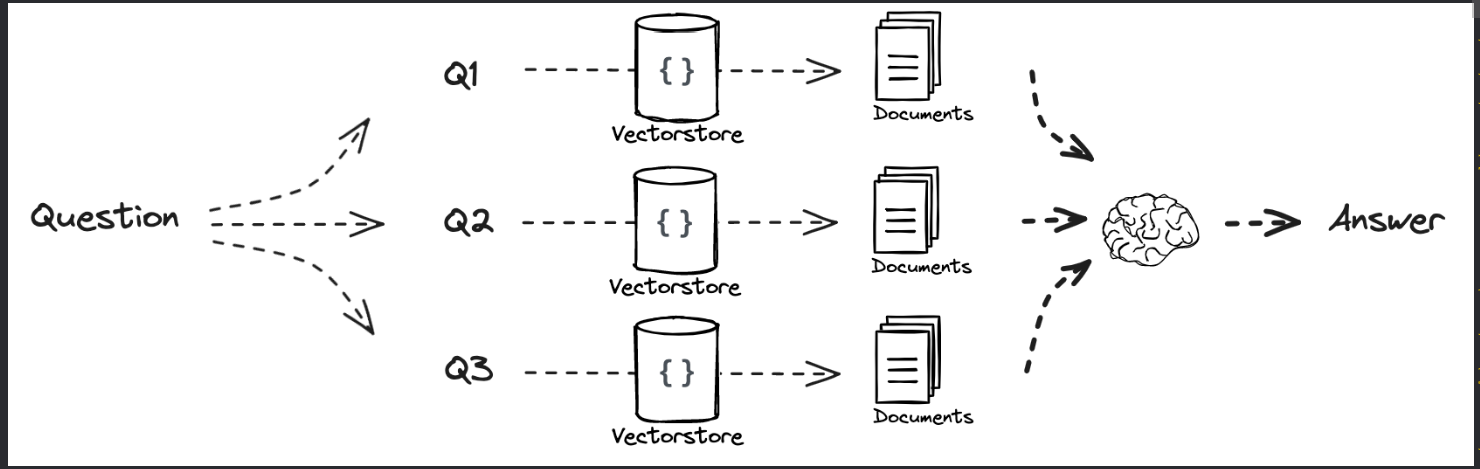

In [ ]:
from IPython.display import Image
# Multiquery system

Image(filename="Screenshot from 2025-05-09 08-58-09.png")


In [ ]:
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from langchain import hub
from dotenv import load_dotenv
load_dotenv()

prompt = hub.pull('rlm/rag-prompt')
from tqdm.autonotebook import tqdm as notebook_tqdm



retriever = vectorize('shreyankresume.pdf').as_retriever()

def format_docs(docs):
    return '\n\n'.join(doc.page_content for doc in docs)


rag_chain = (
    {"context":retriever |format_docs , 'question':RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)


template = """You are an AI language model assistant. Your task is to generate five
different versions of the given user question to retrieve relevant documents from a vector
database. By generating multiple perspectives on the user question, your goal is to help
the user overcome some of the limitations of the distance-based similarity search.
Provide these alternative questions separated by newlines. Original question: {question} """

from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_template(template)

generate_queries = (
    prompt
    | llm
    | StrOutputParser()
    | (lambda x: x.split("\n"))
)
from langchain.load import dumps, loads

def get_unique_union(documents: list[list]):
    """ Unique union of retrieved docs """
    flattened_docs = [dumps(doc) for sublist in documents for doc in sublist]
    unique_docs = list(set(flattened_docs))
    return [loads(doc) for doc in unique_docs]


retrieval_chain = generate_queries | retriever.map() | get_unique_union



from operator import itemgetter
from langchain_core.runnables import RunnablePassthrough

template = """Answer the following question based on this context:

{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)



final_rag_chain = (
    {"context": retrieval_chain,
     "question": itemgetter("question")}
    | prompt
    | llm
    | StrOutputParser()

)






/usr/local/lib/python3.11/dist-packages/langsmith/client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


pdf


In [ ]:
#print(result)

## Fallback Node in Retrieval-Augmented Generation (RAG) System

The **fallback node** is a component in a RAG system designed to handle cases where the initial answer attempt is insufficient or unclear. It evaluates the chat summary, user question, and the initially attempted answer, and decides whether to continue with the answer or provide a fallback response.

### Workflow:

The **fallback node** works as follows:
1. **Review the Chat Summary**: Understand the ongoing conversation context.
2. **Review the Retrieved Context**: Analyze the retrieved context from the RAG system.
3. **Evaluate the Initial Answer**: Evaluate whether the initially attempted answer is sufficient or clear.
4. **Decision**: If the answer is unclear or insufficient, a fallback response is provided. Otherwise, the initial answer is returned.

### Fallback Prompt:

The fallback prompt is used to generate a decision on whether to continue or fall back. The prompt asks the assistant to:
- Review the conversation context and the initial answer.
- Determine if the answer is relevant and sufficient.
- If not, provide a polite fallback response or ask the user to clarify their question.

```python
from langchain_core.prompts import ChatPromptTemplate

fallback_prompt = """
You are a helpful and honest assistant working within a RAG (Retrieval-Augmented Generation) system. You attempted to answer a user's question based on retrieved knowledge, but the information may be incomplete, irrelevant, or not confidently grounded.

Your goal now is to:
- Review the chat summary to understand ongoing conversation context.
- Review the retrieved context.
- Evaluate the initially attempted answer.
- If the context was insufficient or the answer is vague, provide a polite, thoughtful fallback response.
- If helpful, ask the user to clarify or reformulate their question.

---

Chat Summary (Conversation So Far):
{chat_summary}

User Question:
{question}

Initial Answer Attempted:
{answer}

---

Just return 'fall_back' if the answer is NOT good enough.
Return 'continue' if the answer is relevant and sufficient.
"""


In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnableMap, RunnablePassthrough


fallback_prompt = """
You are a helpful and honest assistant working within a RAG (Retrieval-Augmented Generation) system. You attempted to answer a user's question based on retrieved knowledge, but the information may be incomplete, irrelevant, or not confidently grounded.

Your goal now is to:
- Review the chat summary to understand ongoing conversation context.
- Review the retrieved context.
- Evaluate the initially attempted answer.
- If the context was insufficient or the answer is vague, provide a polite, thoughtful fallback response.
- If helpful, ask the user to clarify or reformulate their question.

---

Chat Summary (Conversation So Far):
{chat_summary}

User Question:
{question}

Initial Answer Attempted:
{answer}

---

Just return 'fall_back' if the answer is NOT good enough.
Return 'continue' if the answer is relevant and sufficient.
"""


fall_back_prompt = ChatPromptTemplate.from_template(fallback_prompt)

def fallback_node(state: State) -> dict:
    chat_summary = state.chat_summary
    question = state.question
    answer = state.answer

    # Combine into a runnable chain
    fallback_chain = fall_back_prompt | llm | StrOutputParser()

    # Provide input variables to the chain
    decision = fallback_chain.invoke({
        "chat_summary": chat_summary,
        "question": question,
        "answer": answer
    })

    decision = decision.strip().lower()

    if decision == "continue":
        return {"answer": answer}
    else:
        fallback_response = (
            "Apologies! It seems I don't have enough reliable information to confidently answer your question right now. "
            "This might be due to insufficient or unclear context. "
            "Please consider rephrasing your question or using a more advanced model for better results."
        )
        return {"answer": fallback_response}


In [ ]:
summarizer_prompt = """
You are an expert summarizer. Summarize the entire conversation, including the latest question and answer pair, while preserving the key points.

Previous Summary ignore if its not there:
{previous_summary}

New Question and Answer:
Question: {question}
Answer: {answer}

---

Updated Summary:
"""

import dotenv
dotenv.load_dotenv()

from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model = 'gemini-1.5-flash')

def summarizer_node(state:State):

    question = state.question
    answer = state.answer
    previous_summary = state.chat_summary


    prompt = summarizer_prompt.format(
        previous_summary=previous_summary,
        question=question,
        answer=answer
    )


    updated_summary = llm.invoke(prompt)


    return {"updated_summary": updated_summary}


In [ ]:

from typing import Literal
from langchain_core.runnables import RunnableParallel


class HallucinationGrader(BaseModel):
    "Binary score for hallucination check in llm's response"

    grade: Literal["yes", "no"] = Field(
        ..., description="'yes' if the llm's reponse is hallucinated otherwise 'no'"
    )



## Hallucination Handling and Answer Grading in RAG System

### **Hallucination in AI Models**
Hallucination refers to instances where an AI model generates responses that are not grounded in reality or the provided context. This can occur in a **Retrieval-Augmented Generation (RAG)** system, especially when the model generates answers based on incomplete, irrelevant, or fabricated information.

To handle hallucinations effectively, the system needs to evaluate the relevance and accuracy of its answers based on the retrieved knowledge and decide if the generated response is trustworthy.

---

### **Hallucination Detection and Handling**

To detect and handle hallucinations, the system uses several strategies:

1. **Fallback Node (as previously described)**:
    - **Decision Point**: If the model's generated answer is insufficient or irrelevant, the fallback node determines whether the model should continue or fallback with a clarifying message.
    - **Clarification Request**: If hallucination is detected (i.e., the model provides unreliable information), the fallback response is triggered, asking the user to clarify their question.

2. **Answer Grading**:
    - An automatic grading system is employed to evaluate the quality and accuracy of the generated answer against the retrieved knowledge.
    - This system assigns a score to the answer based on its relevance, factual accuracy, and confidence level.

---

### **Answer Grading System**

The answer grader is designed to evaluate the model's responses and categorize them based on predefined criteria:

1. **Relevance**: Does the answer directly respond to the user’s question?
2. **Accuracy**: Is the information factual and supported by the retrieved knowledge?
3. **Clarity**: Is the answer easy to understand, with a clear structure and language?

#### **Grading Scale**:
The grading scale typically ranges from **1** to **5** (or another appropriate scale), where:
- **5**: Excellent answer, fully accurate and relevant.
- **4**: Good answer, mostly relevant with minimal issues.
- **3**: Fair answer, some relevance and minor inaccuracies.
- **2**: Poor answer, relevant to some extent but contains significant issues.
- **1**: Hallucinated answer, irrelevant or incorrect.

---

### **Grading Workflow Example**

- **Initial Answer Evaluation**: The generated answer is scored based on the grading criteria. If the answer meets the necessary threshold, it is returned to the user.
- **Fallback Activation**: If the answer is graded poorly (e.g., score below 3), a fallback response is triggered, politely informing the user that the answer is insufficient and asking for clarification.

---

### **Combining Hallucination Handling with Grading**

When hallucination occurs, the model’s answer might appear to be well-structured but still lack factual accuracy. The combination of **fallback response** and **answer grading** provides a **double layer of protection**:

1. **Grading** evaluates whether the answer is **useful** based on predefined criteria.
2. **Fallback response** is triggered if the grading score is low, guiding the user to rephrase the query or indicating that more advanced answers might be necessary.

---

### **Example Hallucination Handling and Answer Grading in Code**

Here’s a simplified example of how hallucination handling and answer grading work together:

```python
def grade_answer(answer, context):
    # Simple grading function (this can be more sophisticated)
    score = 0
    if answer in context:
        score = 5  # Perfect match, high relevance and accuracy
    elif answer_is_partially_relevant(answer, context):
        score = 3  # Some relevance, but accuracy or context might be off
    else:
        score = 1  # Hallucinated or completely irrelevant answer
    
    return score

def hallucination_and_grading_handler(state: State) -> dict:
    answer = state.answer
    chat_summary = state.chat_summary
    question = state.question
    context = retrieve_relevant_context(question)
    
    # Grade the answer
    grading_score = grade_answer(answer, context)
    
    if grading_score < 3:  # If the score is below a threshold, trigger fallback
        return {
            "answer": "Apologies! It seems I don't have enough reliable information to confidently answer your question right now. "
                      "This might be due to insufficient or unclear context. Please consider rephrasing your question or using a more advanced model for better results."
        }
    else:
        return {"answer": answer}


In [ ]:
hallucination_grader_system_prompt_template = (
    '''You are a grader assessing whether a response from an LLM is grounded in the given question and the context provided during the retrieval process.
    You will be given the following inputs:
    - The question asked by the user is {question}

    - The answer provided by the RAG application is on the basis of the context is
    {answer}


    Your task is to determine if the LLM's response is based on the context (implicitly retrieved).
    If the LLM's response does not align with the question or context (introduces unrelated information),
    it is considered a hallucination. In such cases, give a score of 'yes' (hallucinated).
    If the LLM's response is grounded in the context and consistent with the question, give a score of 'no' (not hallucinated).

    Just provide your answer in the following JSON format:
     grade: yes  or  grade: no
    No additional explanation is needed.'''


)

hallucination_grader_prompt = ChatPromptTemplate.from_template(hallucination_grader_system_prompt_template)



In [ ]:
def hallucination_grader(state: State):
    hallucination_grader_chain = (
        hallucination_grader_prompt
        | llm.with_structured_output(HallucinationGrader, method="json_mode")
    )


    graded_response = hallucination_grader_chain.invoke({
        'question': state.question,
        'answer': state.answer
    })

    return graded_response


In [ ]:


class AnswerGrader(BaseModel):
    '''Binary score for an answer check based on a query.'''

    grade: Literal["yes", "no"] = Field(
        description="'yes' if the provided answer is an actual answer to the query otherwise 'no',"
    )


answer_grader_system_prompt_template = (
    '''
    You are a grader assessing whether the provided answer is a valid and relevant response to the given query.
    If the provided answer addresses the query correctly, give a score of 'yes'.
    If the provided answer does not answer the query or is irrelevant, give a score of 'no'.
    Just provide your answer in the following JSON format:
    grade: yes or grade: no
    No additional explanation is needed.'''
)


In [ ]:

answer_grader_prompt = ChatPromptTemplate.from_template(answer_grader_system_prompt_template)
answer_grader_chain = answer_grader_prompt | llm.with_structured_output(
        AnswerGrader, method="json_mode"
    )


def answer_grader(state:State):
    answer = state.answer
    question = state.question
    grade = answer_grader_chain.invoke({'question':question,'answer':answer})
    return grade



In [ ]:

def hallucination_and_answer_relevance_check(state:State):


    hallucination_grade = hallucination_grader(state)
    print(f"hallucinatio grade is {hallucination_grade}")
    if hallucination_grade.grade == "no":
        print("---Hallucination check passed---")
        answer_relevance_grade = answer_grader(state)
        print(answer_relevance_grade)
        if answer_relevance_grade.grade == "yes":
            print("---Answer is relevant to question---\n")
            return "useful"
        else:
            print("---Answer is not relevant to question---")
            return "not_useful"
    print("---Hallucination check failed---")
    return "generate"

In [ ]:
def rag_answer(state:State):
    query = state.question
    answer = final_rag_chain.invoke({'question':query})
    return {'answer':answer}

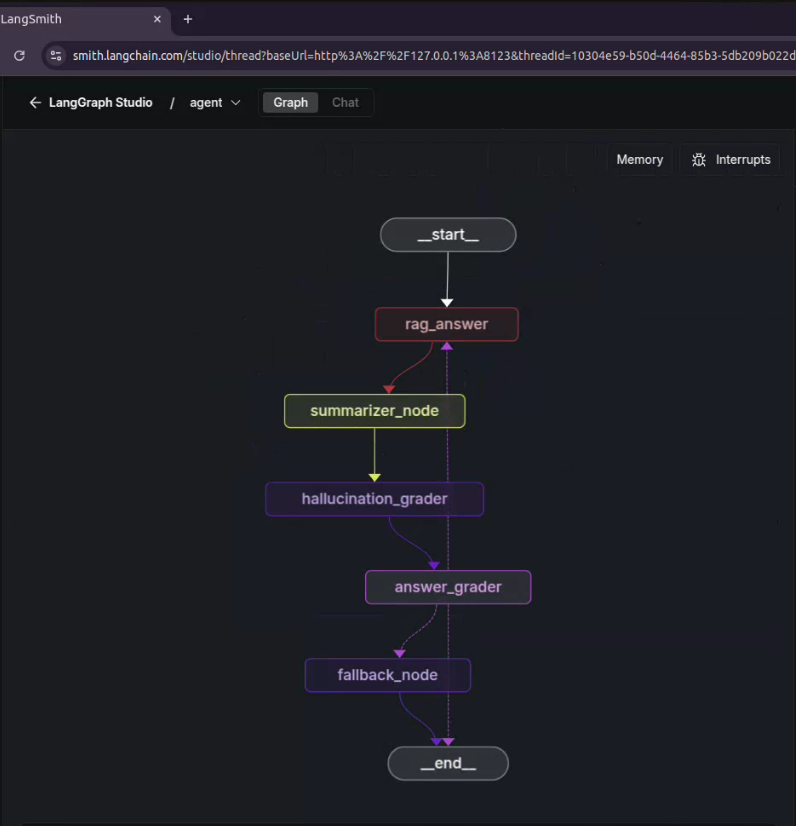

In [ ]:
Image('Screenshot from 2025-05-09 09-11-46.png')

In [ ]:
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import InMemorySaver

builder = StateGraph(State)


builder.add_node("rag_answer", rag_answer)
builder.add_node("summarizer_node", summarizer_node)

builder.add_node("fallback_node", fallback_node)


builder.add_edge(START, "rag_answer")
builder.add_edge("rag_answer", "summarizer_node")


builder.add_conditional_edges(
    "summarizer_node",
    hallucination_and_answer_relevance_check,
   {
        "useful": END,
        "generate": "rag_answer",
        "not_useful": "fallback_node"
    },
)
builder.add_edge("fallback_node", END)

graph = builder.compile(checkpointer=InMemorySaver())

In [ ]:
state = State(question = "What job role is perfect for the candidiate",answer = '',chat_summary = '')

In [ ]:
graph.invoke(state)

In [ ]:
print(graph.get_graph().draw_ascii())